# Project 3.1.1 Data Cleaning and Data Science Process - Finalver2.
---
Following scraping textual information from reddit posts, we now continue with the data science process of data cleaning, EDA, model building, evaluation and lastly recommendation of business solutions.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

# always be stylish
plt.style.use('ggplot')

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import confusion_matrix

In [2]:
# Read in google home reddit data
df_gh = pd.read_csv('./reddit_gh.csv')
df_gh.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,media,is_video,link_flair_template_id,post_hint,preview,media_metadata,crosspost_parent_list,crosspost_parent,author_cakeday,poll_data
0,NaN,googlehome,[\[FAQ - Frequently Asked Questions\]](https:/...,t2_q648wkk,False,NaN,0,False,FAQ: Please read the subreddit FAQ before post...,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,googlehome,Do you want to liberate your Google so it can ...,t2_8hlsb,False,NaN,0,False,My Google has Coronavirus! - Monthly Rants and...,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,googlehome,Because that's all it is.,t2_1mgxh,False,NaN,0,False,[Subreddit Request] Can we rename this subredd...,[],...,NaN,False,489ab03e-b78e-11e6-8fd6-0e00dc2f4472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,googlehome,NaN,t2_mnm0w,False,NaN,0,False,This one really takes the cake.,[],...,NaN,False,NaN,image,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN
4,NaN,googlehome,NaN,t2_me5yarn,False,NaN,0,False,Where did my routines go to? They're still in ...,[],...,NaN,False,0ab35abe-b78e-11e6-9303-0ed3c72a1f42,image,{'images': [{'source': {'url': 'https://previe...,NaN,NaN,NaN,NaN,NaN


The columns with the more relevant textual data are from subreddit, selftext and title. 

In [3]:
# Set a new dataframe with the columns we want ()
df_gh1 = pd.DataFrame(df_gh[['subreddit', 'selftext', 'title']])
# Shape of dataframe
df_gh1.shape

(996, 3)

In [4]:
# Drop duplicates in selftext column
df_gh1.drop_duplicates(subset='selftext',inplace=True)
# Shape of dataframe after removing duplicates
df_gh1.shape

(825, 3)

In [5]:
# Drop NAs.
df_gh1.dropna(inplace=True)
# Shape of dataframe after removing NAs
df_gh1.shape

(824, 3)

In [6]:
# Review first 5 rows of dataframe
df_gh1.head()

,subreddit,selftext,title
0,googlehome,[\[FAQ - Frequently Asked Questions\]](https:/...,FAQ: Please read the subreddit FAQ before post...
1,googlehome,Do you want to liberate your Google so it can ...,My Google has Coronavirus! - Monthly Rants and...
2,googlehome,Because that's all it is.,[Subreddit Request] Can we rename this subredd...
6,googlehome,So I set an alarm there and Google responded '...,Google just said no problem
7,googlehome,Recently got a Nest WiFi router. I currently l...,Nest WiFi - who can access router settings?


In [7]:
# Read in google pixel reddit data
df_gp = pd.read_csv('./reddit_gp.csv')
df_gp.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,event_start,post_hint,preview,event_end,event_is_live,link_flair_template_id,media_metadata,poll_data,crosspost_parent_list,crosspost_parent
0,NaN,GooglePixel,This is the weekly photo megathread. Photos ca...,t2_6l4z3,False,NaN,0,False,Weekly #madebygoogle Photos Megathread - May 0...,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,GooglePixel,*If you were redirected here from a removed po...,t2_zmjf4,False,NaN,0,False,"The May 2020 Superthread: Pixel 4a, Battery, ""...",[],...,1.588345e+09,self,{'images': [{'source': {'url': 'https://extern...,1.588360e+09,False,NaN,NaN,NaN,NaN,NaN
2,NaN,GooglePixel,It was supposed to take up to 10 days. But it ...,t2_10j65hn2,False,NaN,0,False,"So I had some troubles with my phone, and sent...","[{'e': 'text', 't': 'Pixel 3a'}]",...,NaN,NaN,NaN,NaN,NaN,bd247e74-7476-11e9-b802-0e2121dcd2a2,NaN,NaN,NaN,NaN
3,NaN,GooglePixel,Yall weren't kidding about the battery. It's p...,t2_zfetx,False,NaN,0,False,Had my pixel 4 for a few days already and holy...,"[{'e': 'text', 't': 'Pixel 4'}]",...,NaN,NaN,NaN,NaN,NaN,8697ce76-f2dc-11e9-8412-0eae23347634,NaN,NaN,NaN,NaN
4,NaN,GooglePixel,NaN,t2_bkfyp,False,NaN,0,False,Pixel 3a black screen after overnight charging,"[{'e': 'text', 't': 'Pixel 3a'}]",...,NaN,hosted:video,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,bd247e74-7476-11e9-b802-0e2121dcd2a2,NaN,NaN,NaN,NaN


In [8]:
# Set a new dataframe with the columns we want ()
df_gp1 = pd.DataFrame(df_gp[['subreddit', 'selftext', 'title']])
# Shape of dataframe
df_gp1.shape

(980, 3)

In [9]:
# Drop duplicates in selftext column
df_gp1.drop_duplicates(subset='selftext',inplace=True)
# Shape of dataframe after removing duplicates
df_gp1.shape

(803, 3)

In [10]:
# Drop NAs.
df_gp1.dropna(inplace=True)
# Shape of dataframe after removing NAs
df_gp1.shape

(802, 3)

In [11]:
# Join the two dataframes together
df = pd.concat([df_gh1,df_gp1])
df.reset_index(drop=True, inplace=True)
# Shape of concatenated dataframe 
df.shape

(1626, 3)

In [12]:
df['subreddit'].value_counts()

googlehome     824
GooglePixel    802
Name: subreddit, dtype: int64

In [13]:
# Engineer a feature to turn subreddit into a 1/0 column, where 1 indicates googlehome.
df['googlehome'] = df['subreddit'].map({'googlehome': 1, 'GooglePixel': 0})
df.head(2)

,subreddit,selftext,title,googlehome
0,googlehome,[\[FAQ - Frequently Asked Questions\]](https:/...,FAQ: Please read the subreddit FAQ before post...,1
1,googlehome,Do you want to liberate your Google so it can ...,My Google has Coronavirus! - Monthly Rants and...,1


In [14]:
df['googlehome'].value_counts(normalize=True)

1    0.506765
0    0.493235
Name: googlehome, dtype: float64

The distribution of the classes is quite balanced. If the class is imblanced, the resulting model is likely to have low predictive accuracy for the infrequent class.

### Basic EDA
---
Building good performing classifers from data with easily separable classes is relatively straightforward but care should be excercised to determine if such data is representative of the actual world environment. In most real world environment, samples from different classes share similar characteristics or are overlapped. This means the boundaries of each class may not be clearly defined as desired. 

Common practices to address this problem includes:
- i) modifying the original data by introducing/removing features which decrease the overlapping region,
- ii) adapting algorithms to reduce the negative impact of overlapping features.

Through the basic EDA process, we set out to discover what are the prevalent key words among the reddit posts, and their distribution across text data of googlehome and googlepixel reddit posts. With these insights we would then be in better position to fine-tune the subsequent models.

In [15]:
text = df['selftext']
text[0:5]

0    [\[FAQ - Frequently Asked Questions\]](https:/...
1    Do you want to liberate your Google so it can ...
2                            Because that's all it is.
3    So I set an alarm there and Google responded '...
4    Recently got a Nest WiFi router. I currently l...
Name: selftext, dtype: object

In [16]:
'''
create a document term matrix with:
-ngram range 1,2
-minimum document appearance for any term = 2
-removal of all English stop words
'''
# Instantiate countvectorizer
cvec = CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=2)
matrix = cvec.fit_transform(text)

In [17]:
# Create a dataframe with feature names = words
tf = pd.DataFrame(cvec.fit_transform(text).toarray(), columns=cvec.get_feature_names())

In [18]:
# see most common terms
tf.sum().sort_values(ascending=False).head(10)

google         1731
home           1054
pixel           993
phone           882
just            736
google home     606
buds            559
ve              547
like            533
app             429
dtype: int64

In [19]:
# Create googlehome text df
googlehome_tdf = df[df['googlehome'] ==1]
googlehome_tdf.shape
googlehome_tdf.head()

,subreddit,selftext,title,googlehome
0,googlehome,[\[FAQ - Frequently Asked Questions\]](https:/...,FAQ: Please read the subreddit FAQ before post...,1
1,googlehome,Do you want to liberate your Google so it can ...,My Google has Coronavirus! - Monthly Rants and...,1
2,googlehome,Because that's all it is.,[Subreddit Request] Can we rename this subredd...,1
3,googlehome,So I set an alarm there and Google responded '...,Google just said no problem,1
4,googlehome,Recently got a Nest WiFi router. I currently l...,Nest WiFi - who can access router settings?,1


In [20]:
# Create googlepixel text df
googlepixel_tdf = df[df['googlehome'] == 0]
googlepixel_tdf.shape

(802, 4)

In [21]:
# vectorize selftext from googlehome text
tf1 = pd.DataFrame(cvec.fit_transform(googlehome_tdf['selftext']).toarray(), columns=cvec.get_feature_names())

In [22]:
# No.of features fitted
tf1.shape

(824, 4502)

In [23]:
# check value counts
tf1.sum().sort_values(ascending=False).head(10)

google         1260
home            992
google home     600
just            312
play            283
app             265
ve              254
nest            248
set             246
mini            230
dtype: int64

As expected, the words `google`, `home` and `google home` have high prevalence in google home reddit posts.

In [24]:
# vectorize selftext from googlehome text
tf2 = pd.DataFrame(cvec.fit_transform(googlepixel_tdf['selftext']).toarray(), columns=cvec.get_feature_names())

In [25]:
# No.of features fitted
tf2.shape

(802, 5352)

In [26]:
# check value counts
tf2.sum().sort_values(ascending=False).head(10)

pixel         980
phone         672
buds          559
google        471
just          424
like          321
ve            293
pixel buds    265
battery       225
don           208
dtype: int64

The words `google`, `phone` and `pixel` have high prevalence in google pixel reddit posts. Are any of these words common among the two reddit groups, and what is their distribution? Let's find out.

In [27]:
# word counts of googlehome text and google pixel text
"""Merge the two dataframes on Outer join, align with both dataframe indexes."""
word_counts = pd.merge(pd.DataFrame(data=tf1.sum().sort_values(ascending=False)),\
                       pd.DataFrame(data=tf2.sum().sort_values(ascending=False)),\
                       how='outer',left_index=True,right_index=True)
print(word_counts)

              0_x   0_y
00            4.0   2.0
04            NaN   5.0
05            NaN   2.0
09            NaN   2.0
10           38.0  77.0
...           ...   ...
zero issues   NaN   2.0
zoom          NaN  24.0
zoom app      NaN   2.0
zoom video    NaN   2.0
zoomed        NaN   2.0

[8019 rows x 2 columns]


In [28]:
# rename columns
word_counts.columns = ['googlehome', 'googlepixel']

In [29]:
# view the df to ensure correct column naming
word_counts.head(2)

,googlehome,googlepixel
00,4.0,2.0
04,NaN,5.0


In [30]:
# find sums
word_counts['sum'] = word_counts['googlehome'] + word_counts['googlepixel']
# sort by most used values
word_counts.sort_values(['sum'], ascending=False).head(10)

,googlehome,googlepixel,sum
google,1260.0,471.0,1731.0
home,992.0,62.0,1054.0
pixel,13.0,980.0,993.0
phone,210.0,672.0,882.0
just,312.0,424.0,736.0
google home,600.0,6.0,606.0
ve,254.0,293.0,547.0
like,212.0,321.0,533.0
app,265.0,164.0,429.0
use,197.0,177.0,374.0


In [31]:
# Minimum occurrence of words
word_counts.sort_values(['sum'], ascending=True).head(5)

,googlehome,googlepixel,sum
does recognize,2.0,2.0,4.0
google help,2.0,2.0,4.0
just getting,2.0,2.0,4.0
refusing,2.0,2.0,4.0
app issue,2.0,2.0,4.0


In [136]:
# expt
tf2

,00,04,05,09,10,10 battery,10 days,10 desktop,10 minutes,10 month,...,youtube video,youtube videos,yt,yt music,zero,zero issues,zoom,zoom app,zoom video,zoomed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


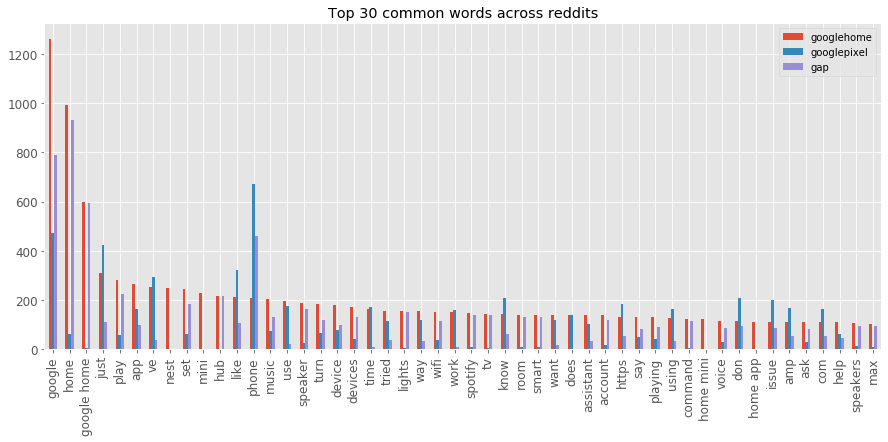

In [137]:
# plot 30 most used words
word_counts.sort_values(['googlehome','googlepixel'], ascending=False).drop('sum', axis=1).head(30).\
plot(kind='bar',figsize=(15,6),fontsize=12,title='Top 30 common words across reddits');

In [33]:
print(f"googlehome total posts: {df_gh1.shape[0]}, word count: {word_counts['googlehome'].sum()}")
print(f"googlepixel total posts: {df_gp1.shape[0]}, word count: {word_counts['googlepixel'].sum()}")

googlehome total posts: 824, word count: 39648.0
googlepixel total posts: 802, word count: 45369.0


While the word `google` is unexpectedly common with 1731 instances, an interestingly observation is that it is not as prevalent for google pixel posts compared to google home. This could be due to consumers referring the google handphone simply as `pixel`. 
For (binary) classification problem, the ideal case is perfect separation in features for the classes. However, this is rarely the case in actual world environment. 

To improve generalizability of the model, certain words that help with distinct classification are also removed. These are (`First set words`): ['google', 'home', 'google home', 'nest', 'mini', 'hub' and 'pixel']. Observe that there are words that are common between `googlehome` and `googlepixel`. We will also remove words (`Second set words`) that have following two characteristics:
- significant overlaps (smallest difference in word count occurrence in both classes)
- occur frequently. From the plot above, word count occurrence of more than 200 is determined emphirically to be a suitable  measure. 

The approach would thus be to evaluate model performance on removal of `First set words` followed by removing both `First set words` and `Second set words`. 

In [34]:
# find words with 
# 1. significant overlaps
# 2. measure by gap (difference of word count between googlehome & googlepixel class)
# 3. identify the more significant occuring ones by population proportion
word_counts['gap'] = abs(word_counts['googlehome'] - word_counts['googlepixel'])
# sort by most used values
word_counts.sort_values(['gap'], ascending=True).loc[(word_counts['sum']>300) & (word_counts['gap']<50)]

,googlehome,googlepixel,sum,gap
work,150.0,158.0,308.0,8.0
time,164.0,174.0,338.0,10.0
use,197.0,177.0,374.0,20.0
ve,254.0,293.0,547.0,39.0


In [35]:
word_counts.sort_values(['gap'], ascending=True).loc[(word_counts['sum']>200) & (word_counts['gap']<50)]

,googlehome,googlepixel,sum,gap
does,138.0,140.0,278.0,2.0
work,150.0,158.0,308.0,8.0
time,164.0,174.0,338.0,10.0
want,139.0,120.0,259.0,19.0
use,197.0,177.0,374.0,20.0
using,129.0,162.0,291.0,33.0
way,155.0,121.0,276.0,34.0
assistant,138.0,102.0,240.0,36.0
ve,254.0,293.0,547.0,39.0
tried,156.0,116.0,272.0,40.0


The top 10 words commonly overlapping words are [`does`, `work`, `time`, `want`, `use`, `using`, `way`, `assistant`, `ve`, `tried`] are the more common words among the two reddits with significant overlap (similar distribution, with word count aprrox. 200). To measure the impact on model predictive accuracy, it is proposed compare a logreg model without removing these key words and another logreg model with these key words removed.  

### Word Art
---
Following the EDA process, we received a request from the marketing department. They wanted to understand the hot topics for google home and google pixel by inference of the keywords from Reddit posts. While word cloud is technically not data science, we make a small detour to help them out.

In [36]:
# Import libraries
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from matplotlib.pyplot import imread
%matplotlib inline

import numpy as np

In [37]:
# create a list of all the text from googlehome
wa_gh = pd.DataFrame(cvec.fit_transform(googlehome_tdf['selftext']).toarray(), columns=cvec.get_feature_names())
all_textgh = []
for x in wa_gh:
    all_textgh.append(x)

In [38]:
# create a list of all the text from googlepixel
wa_gp = pd.DataFrame(cvec.fit_transform(googlepixel_tdf['selftext']).toarray(), columns=cvec.get_feature_names())
all_textgp = []
for x in wa_gp:
    all_textgp.append(x)

In [39]:
# format it into str
# In Python 3, unicode has been renamed to str.
googlehome_text = str(all_textgh)
googlepixel_text = str(all_textgp)

In [40]:
# Define function to generate wordart (wordcloud)
def cloud(source_text):
    stop_words = ["ve'"] + list(STOPWORDS)
    wordcloud = WordCloud(max_words=200,\
                          stopwords=stop_words,\
                          background_color="white",\
                          min_font_size=10,\
                          colormap='viridis').generate(source_text)
    
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

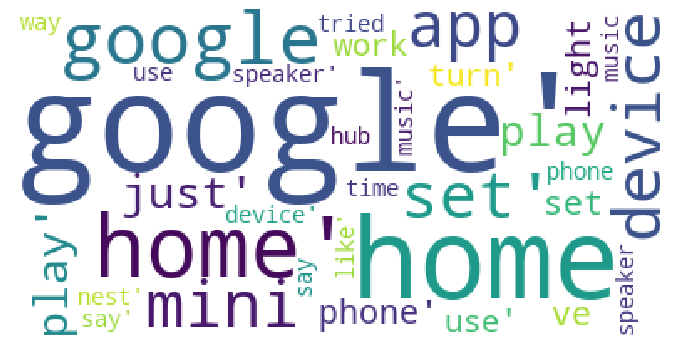

In [41]:
# Generate word cloud image for googlehome
cloud(googlehome_text)

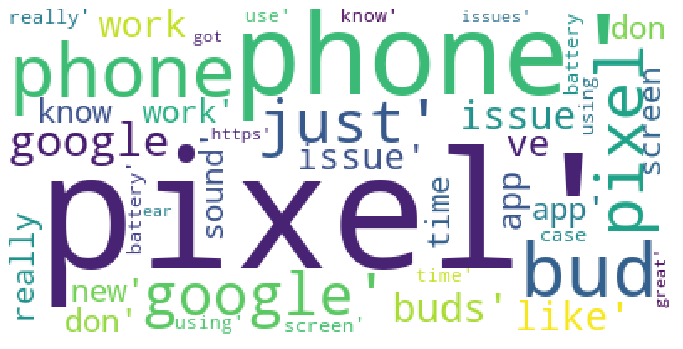

In [42]:
# Generate word cloud image for googlepixel
cloud(googlepixel_text)

### Model Prep
---
In model learning, data is usually segregated into 
- training set; where model learns from the pattern within this set of data,
- validate set; where model or group of models are evaluated. This is the performance the model is expected to have on unseen data.  
- test set; the best performing model is then shortlisted and tested on the test set.

We first split data into i) train and test set, then split the train set into train subsets and validate subsets.

Dataleakage is an issue where a learned model is overfitted on the train data and not generalize well to new, unseen data. This can be mitigated by spliting the data upfront, fitting only on the train set and transform the validate set. This is to prevent data leakage from the validate set to the train set. (Similar principle applies on test set). This also means excercise caution not to inadvertently countvectorize (a transformer) the data first before doing train-test-split.

In [43]:
# Create Train-Test split (80-20 split)
# X is selftext. y is googlehome.
X_train,X_test,y_train,y_test = train_test_split(df[['selftext']],df['googlehome'],test_size=0.20,\
                                                 stratify=df['googlehome'],\
                                                 random_state=42)

In [44]:
# Equal proportion of classes split across train and test set
print(y_train.value_counts())
y_test.value_counts()

1    659
0    641
Name: googlehome, dtype: int64


1    165
0    161
Name: googlehome, dtype: int64

In [45]:
# Create Train-Validate subsets (80-20 split) from the parent Train set
# X is selftext. y is googlehome.
X_trainf,X_validate,y_trainf,y_validate = train_test_split(X_train[['selftext']],y_train,test_size=0.20,\
                                                           stratify=y_train,random_state=42)

In [46]:
# Lines of text in train set, validate set and test set
lines_trainf = X_trainf.shape[0]
lines_validate = X_validate.shape[0]
lines_test = X_test.shape[0]
print(f"Lines in train set: {lines_trainf}.")
print(f"Lines in validate set: {lines_validate}.")
print(f"Lines in test set: {lines_test}.")

Lines in train set: 1040.
Lines in validate set: 260.
Lines in test set: 326.


In [47]:
# Instantiate porterstemmer
p_stemmer = PorterStemmer()

In [48]:
# Define function to convert a raw selftext to a string of words
# The input is a single string (a raw selftext), and 
# the output is a single string (a preprocessed selftext)

def selftext_to_words(raw_selftext):
    
    # 1. Remove HTML.
    selftext_text = BeautifulSoup(raw_selftext).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", selftext_text)
    
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))

    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 5.5 Stemming of words
    meaningful_words = [p_stemmer.stem(w) for w in words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result
    return(" ".join(meaningful_words))

In [49]:
#Initialize an empty list to hold the clean reviews.
X_trainf_clean = []
X_validate_clean = []
X_test_clean = []

#For train set
# Instantiate counter.
j = 0
for text in X_trainf['selftext']:
    """Convert text to words, then append to X_trainf_clean."""
    X_trainf_clean.append(selftext_to_words(text))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % 1000 == 0:
        print(f'Clean & parse {j + 1} of {lines_trainf+lines_validate+lines_test}.')
    
    j += 1
    
# For validate set
for text in X_validate['selftext']:
    """Convert text to words, then append to X_validate_clean."""
    X_validate_clean.append(selftext_to_words(text))
    
    # If the index is divisible by 1629, print a message.
    if (j + 1) % (lines_trainf+lines_validate+lines_test) == 0:
        print(f'Clean and parse {j + 1} of {lines_train+lines_test}.')
    
    j += 1
    
# For test set
for text in X_test['selftext']:
    """Convert text to words, then append to X_test_clean."""
    X_test_clean.append(selftext_to_words(text))
    
    # If the index is divisible by 1629, print a message.
    if (j + 1) % (lines_trainf+lines_validate+lines_test) == 0:
        print(f'Clean and parse {j + 1} of {lines_trainf+lines_validate+lines_test}.')
    
    j += 1

C:\Users\65943\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://imgur.com/a/Wp9EwEn" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\65943\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://imgur.com/a/obeUnIH" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\65943\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://imgur.com/a/telb95S" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that

Clean & parse 1000 of 1626.
Clean and parse 1626 of 1626.


### Baseline accuracy
---
We first derive the baseline accuracy so as to be able to determine if the subsequent models are better than the baseline (null) model (predicting the plurality class).

In [50]:
y_test.value_counts(normalize=True)

1    0.506135
0    0.493865
Name: googlehome, dtype: float64

The Baseline accuracy is the percentage of the majority class. In this case, the baseline accuracy is 0.506135. 
This serves as benchmark for measuring model performance (i.e. model accuracy should be higher than this baseline).

In [138]:
# Review of the X_test_clean words
# Because some of the words were stemmatized
# google converted to googl
# excercise care when removing these words subsequently
X_test_clean

['so i bought pixel after my phone die and i m struggl sinc i m have hard time to unlock my phone when i m lie or in the night becaus it doe not recogn my face the button are not exist sometim i want to do home it it scroll down sometim i want to scroll to the side in the play store and it click back on android click home twice will bring my last use app here there is some weird diagon swing that i haven t figur out yet or manag to do it of the time sinc there are no button i find it harder to oper it in one hand but mayb the fact that i don t have cover for it yet is the reason so i guess that some folk here made thi transit too do you guy have some tip to make the use experi more smooth',
 'hello i have a pixel xl the last time i use it wa about a week ago and i use it again today and notic it wa dead so i charg it and it came on but wa on a load screen with the googl logo for the whole night and i tri to restart it from there and i haven t been abl to turn it on sinc',
 'but make su

### Logistic Regression Model
---
For this project, Logistic Regression and Naive Bayes models are explored. Logistic Regression models are examined in this section.

In [225]:
# Set up a pipeline with two stages
# 1.CountVectorizer (transformer)
# 1.1 ['google', 'home', 'google home', 'nest', 'mini' and 'hub'] words remove to improve model generalizivity
# 2.LogisticRegression (estimator)
pipe1 = Pipeline([('cvec',CountVectorizer(stop_words=['googl', 'home', 'googl home', 'googlehom',\
                                                      'pixel', 'googlepixel', 'nest', 'mini', 'hub'])),\
                 ('logreg',LogisticRegression(solver='lbfgs',max_iter=200,random_state=42))\
                ])

In [226]:
# Parameters of pipeline object
pipe1.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None,
                   stop_words=['googl', 'home', 'googl home', 'googlehom', 'pixel',
                               'googlepixel', 'nest', 'mini', 'hub'],
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('logreg',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=200,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'cvec': CountVec

In [227]:
# Load pipeline object into GridSearchCV to tune CountVectorizer
# Search over the following values of hyperparameters:
# Maximum number of features fit (top no. frequent occur words): 2000, 3000, 4000, 5000
# Minimum number of documents (collection of text) needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

# n-gram: 1 token, 1-gram, or 1 token, 2-gram.
pipe_params = {
    'cvec__max_features': [2_000,3_000,4_000,5_000],\
    'cvec__min_df': [2,3],\
    'cvec__max_df': [0.9,0.95],\
    'cvec__ngram_range': [(1, 1), (1,2)]\
}

In [228]:
# Instantiate GridSearchCV.
"""pipe refers to the object to optimize."""
"""param_grid refer to parameter values to search."""
"""cv refers to number of cross-validate fold."""
gs1 = GridSearchCV(pipe1,\
                  param_grid=pipe_params,\
                  cv=10)

In [229]:
# Fit GridSearch to the cleaned training data.
gs1.fit(X_trainf_clean,y_trainf)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        pre

In [230]:
# Check the results of the grid search

print(f"Best parameters: {gs1.best_params_}")
print(f"Best score: {gs1.best_score_}")

Best parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}
Best score: 0.8884615384615385


In [231]:
# Save best model as gs1_model.

gs1_model = gs1.best_estimator_

In [232]:
# Score model on training set & testing set
print(f"Accuracy on train set: {gs1_model.score(X_trainf_clean, y_trainf)}")
print(f"Accuracy on validate set: {gs1_model.score(X_validate_clean, y_validate)}")

Accuracy on train set: 0.9971153846153846
Accuracy on validate set: 0.8730769230769231


The model accuracy is higher than the baseline accuracy (0.506). However, the model is overfitted with about 12% drop in test accuracy compared to train accuracy.

In [233]:
# Confusion matrix on the first log reg model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is googlehome
preds = gs1.predict(X_validate_clean)
cm = confusion_matrix(y_validate, preds)
cm_df = pd.DataFrame(cm,columns=['pred googlepixel','pred googlehome'], index=['Actual googlepixel','Actual googlehome'])
cm_df

,pred googlepixel,pred googlehome
Actual googlepixel,108,20
Actual googlehome,13,119


The positive class (class 1) refers to `googlehome`. False positive means the observation is classified as `googlehome` when it is actually `googlepixel`. 
False negative means the ovservation is classified as `googlepixel` when it is actually `googlehome`.

In [234]:
# return nparray as a 1-D array.
confusion_matrix(y_validate, preds).ravel()
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_validate,preds).ravel()

In [235]:
# Summary of metrics for first log reg model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")

Specificity: 0.8438
Sensitivity: 0.9015


The Receiver Operating Characteristic curve is a way to visualize the overlap between our positive class and negative class by moving our classification threshold from 0 to 1. 

The ROC curve shows the trade-off between sensitivity (or TruePositiveRate) and specificity (1 – FalsePositiveRate). Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a no-skill classifier is expected to give points lying along the diagonal (FPRate = TPRate). The closer the curve is to the diagonal line, the less accurate the classifier is. 

Hence, the more area under the blue curve, the better separated the class distributions are. The best trade-off between sensitivity and specificity is the top-left point along the ROC curve.

In [236]:
# To visualize the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our validate set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in gs1.predict_proba(X_validate_clean)]

pred_df = pd.DataFrame({'validate_values': y_validate,
                        'pred_probs':pred_proba})
pred_df.head()

,validate_values,pred_probs
1445,0,0.112767
1152,0,0.000006
216,1,0.464080
1001,0,0.001519
1120,0,0.103259


In [237]:
# Import roc_auc_score.
from sklearn.metrics import roc_auc_score

In [238]:
# Calculate ROC AUC.
roc_auc_score(pred_df['validate_values'],pred_df['pred_probs'])

0.9632753314393939

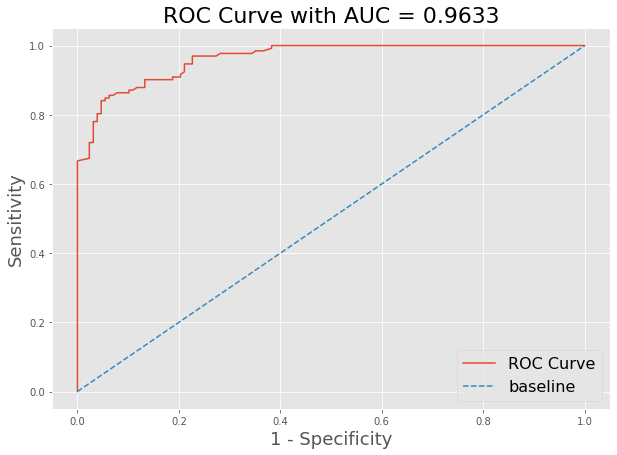

In [239]:
#Create figure
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed orange line in plot.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["validate_values"], pred_df["pred_probs"]),4)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

An ROC AUC of 1 means the positive and negative populations are perfectly separated and that the model is as good as it can get. The closer the ROC AUC is to 1, the better. (1 is the maximum score.)

What would be the impact on model accuracy with the removal of the discovered overlapping key words? Let's find out.

In [240]:
# Set up a pipeline, pipe2 with two stages
# 1.CountVectorizer (transformer)
# 1.1 ['google', 'home', 'google home', 'nest', 'mini' and 'hub'] words remove to improve model generalizivity
# 2.LogisticRegression (estimator)
# 3.Remove the words ['does', 'work', 'time', 'want', 'use', 'using', 'way', 'assistant', 've', 'tried'] 
# via CountVectorizer
pipe2 = Pipeline([('cvec',CountVectorizer(stop_words=['googl', 'home', 'googl home', 'googlehom','pixel', 'googlepixel',\
                                                      'nest', 'mini', 'hub', 'does', 'work', 'time', 'want', 'use',\
                                                      'using', 'way', 'assistant', 've', 'tried'])),\
                  ('logreg',LogisticRegression(solver='lbfgs',max_iter=200,random_state=42))\
                 ])

In [241]:
# Parameters of pipeline object
pipe2.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None,
                   stop_words=['googl', 'home', 'googl home', 'googlehom', 'pixel',
                               'googlepixel', 'nest', 'mini', 'hub', 'does',
                               'work', 'time', 'want', 'use', 'using', 'way',
                               'assistant', 've', 'tried'],
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('logreg',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=200,
                      multi_class='auto', n_jobs=None, penalty='l2',
            

In [242]:
# Load pipeline object into GridSearchCV to tune CountVectorizer
# Search over the following values of hyperparameters:
# Maximum number of features fit (top no. frequent occur words): 2000, 3000, 4000, 5000
# Minimum number of documents (collection of text) needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

# n-gram: 1 token, 1-gram, or 1 token, 2-gram.
pipe2_params = {
    'cvec__max_features': [2_000,3_000,4_000,5_000],\
    'cvec__min_df': [2,3],\
    'cvec__max_df': [0.9,0.95],\
    'cvec__ngram_range': [(1, 1), (1,2)]\
}

In [243]:
# Instantiate GridSearchCV.
"""pipe refers to the object to optimize."""
"""param_grid refer to parameter values to search."""
"""cv refers to number of cross-validate fold."""
gs2 = GridSearchCV(pipe2,\
                  param_grid=pipe2_params,\
                  cv=10)

In [244]:
# Fit GridSearch to the cleaned training data.
gs2.fit(X_trainf_clean,y_trainf)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        pre

In [245]:
print(f"Best parameters: {gs2.best_params_}")
print(f"Best score: {gs2.best_score_}")

Best parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}
Best score: 0.8884615384615385


In [246]:
# Save best model as gs2_model.

gs2_model = gs2.best_estimator_

In [247]:
# Score model on training set & testing set
print(f"First Logistic Regression Model")
print(f"Accuracy on train set: {gs1_model.score(X_trainf_clean, y_trainf)}")
print(f"Accuracy on validate set: {gs1_model.score(X_validate_clean, y_validate)}")
print()
print(f"Second Logistic Regression Model")
print(f"Accuracy on train set: {gs2_model.score(X_trainf_clean, y_trainf)}")
print(f"Accuracy on validate set: {gs2_model.score(X_validate_clean, y_validate)}")

First Logistic Regression Model
Accuracy on train set: 0.9971153846153846
Accuracy on validate set: 0.8730769230769231

Second Logistic Regression Model
Accuracy on train set: 0.9971153846153846
Accuracy on validate set: 0.8653846153846154


The removal of the identified key words has slightly reduced the prediction accuracy on the validate set. Effect of overfit more pronounced in the second logistic regression model.

In [248]:
# Confusion matrix on the second log reg model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is googlehome
preds2 = gs2.predict(X_validate_clean)
cm = confusion_matrix(y_validate, preds2)
cm_df = pd.DataFrame(cm,columns=['pred googlepixel','pred googlehome'], index=['Actual googlepixel','Actual googlehome'])
cm_df

,pred googlepixel,pred googlehome
Actual googlepixel,106,22
Actual googlehome,13,119


The removal of the common overlapping words led to a slight increase in the number of false positives and false negatives.

In [249]:
# return nparray as a 1-D array.
confusion_matrix(y_validate, preds2).ravel()
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_validate,preds2).ravel()

In [250]:
# Summary of metrics for second log reg model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")

Specificity: 0.8281
Sensitivity: 0.9015


Compared to the first logistic regression model, the second logistic regression model has almost similar specificity (True Negative Rate) and sensitivity (True Positive Rate) values. 

In [251]:
# To visualize the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our validate set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in gs2.predict_proba(X_validate_clean)]

pred_df = pd.DataFrame({'validate_values': y_validate,
                        'pred_probs':pred_proba})
pred_df.head()

,validate_values,pred_probs
1445,0,0.108936
1152,0,0.000004
216,1,0.486618
1001,0,0.001455
1120,0,0.115972


In [252]:
# Calculate ROC AUC.
roc_auc_score(pred_df['validate_values'],pred_df['pred_probs'])

0.9626834753787878

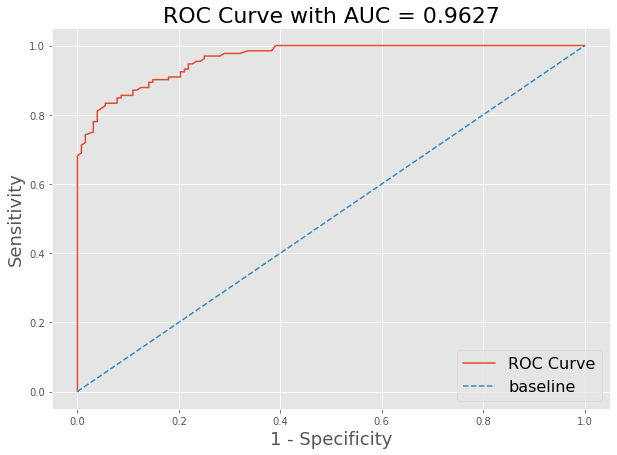

In [253]:
#Create figure
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed orange line in plot.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["validate_values"], pred_df["pred_probs"]),4)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

Compared the second logistic regression model with the first, we see that effect in removal of the identified common overlapping words has a small but negligible effect on the roc_auc.

### Naive Bayes Model
---
We explore the Naive Bayes Model, and apply the removal of identifed common overlapped words identified earlier. 

In [254]:
# Set up a pipeline, p3 with two stages
# 1.CountVectorizer (transformer)
# 1.1 ['google', 'home', 'google home', 'nest', 'mini' and 'hub'] words remove to improve model generalizivity
# 2.Naive Bayes(multinomial) (estimator)
pipe3 = Pipeline([('cvec',CountVectorizer(stop_words=['googl', 'home', 'googl home', 'googlehom',\
                                                      'pixel', 'googlepixel', 'nest', 'mini', 'hub'])),\
                  ('nb',MultinomialNB())\
                 ])

In [255]:
# Parameters of pipeline object
pipe3.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None,
                   stop_words=['googl', 'home', 'googl home', 'googlehom', 'pixel',
                               'googlepixel', 'nest', 'mini', 'hub'],
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
 'verbose': False,
 'cvec': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None,
           

In [256]:
# Load pipeline object into GridSearchCV to tune CountVectorizer
# Search over the following values of hyperparameters:
# Maximum number of features fit (top no. frequent occur words): 2000, 3000, 4000, 5000
# Minimum number of documents (collection of text) needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

# n-gram: 1 token, 1-gram, or 1 token, 2-gram.
pipe_params = {
    'cvec__max_features': [2_000,3_000,4_000,5_000],\
    'cvec__min_df': [2,3],\
    'cvec__max_df': [0.9,0.95],\
    'cvec__ngram_range': [(1, 1), (1,2)]\
}

In [257]:
# Instantiate GridSearchCV.
"""pipe refers to the object to optimize."""
"""param_grid refer to parameter values to search."""
"""cv refers to number of cross-validate fold."""
gs3 = GridSearchCV(pipe3,\
                  param_grid=pipe_params,\
                  cv=10)

In [258]:
# Fit GridSearch to the cleaned training data.
gs3.fit(X_trainf_clean,y_trainf)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        pre

In [259]:
print(f"Best parameters: {gs3.best_params_}")
print(f"Best score: {gs3.best_score_}")

Best parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}
Best score: 0.9096153846153847


In [260]:
# Save best model as gs3_model.

gs3_model = gs3.best_estimator_

In [261]:
# Score model on training set & testing set
print(f"First Logistic Regression Model")
print(f"Accuracy on train set: {gs1_model.score(X_trainf_clean, y_trainf)}")
print(f"Accuracy on validate set: {gs1_model.score(X_validate_clean, y_validate)}")
print()
print(f"First Naive Bayes Model")
print(f"Accuracy on train set: {gs3_model.score(X_trainf_clean, y_trainf)}")
print(f"Accuracy on validate set: {gs3_model.score(X_validate_clean, y_validate)}")

First Logistic Regression Model
Accuracy on train set: 0.9971153846153846
Accuracy on validate set: 0.8730769230769231

First Naive Bayes Model
Accuracy on train set: 0.9528846153846153
Accuracy on validate set: 0.8961538461538462


The naive bayes is overfitted on the train data, with lower validate accuracy compared to the train accuracy. Compared to the first logistic regression model, it has a similar gap (also about 6%) between train accuracy and validate accuracy. In terms of accuracy, it is performing better than the logisitc regression models.

We review the sensitivity and specificity, and roc_auc scores next.

In [262]:
# Confusion matrix on the first naive bayes model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is googlehome
preds3 = gs3.predict(X_validate_clean)
cm = confusion_matrix(y_validate, preds3)
cm_df = pd.DataFrame(cm,columns=['pred googlepixel','pred googlehome'], index=['Actual googlepixel','Actual googlehome'])
cm_df

,pred googlepixel,pred googlehome
Actual googlepixel,112,16
Actual googlehome,11,121


In [263]:
# return nparray as a 1-D array.
confusion_matrix(y_validate, preds3).ravel()
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_validate,preds3).ravel()

In [264]:
# Summary of metrics for first naive bayes model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")

Specificity: 0.875
Sensitivity: 0.9167


In [265]:
# To visualize the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in gs3.predict_proba(X_validate_clean)]

pred_df = pd.DataFrame({'validate_values': y_validate,
                        'pred_probs':pred_proba})
pred_df.head()

,validate_values,pred_probs
1445,0,1.189434e-10
1152,0,4.492673e-22
216,1,9.884097e-01
1001,0,2.755636e-11
1120,0,6.300529e-09


In [266]:
# Calculate ROC AUC.
roc_auc_score(pred_df['validate_values'],pred_df['pred_probs'])

0.9615293560606061

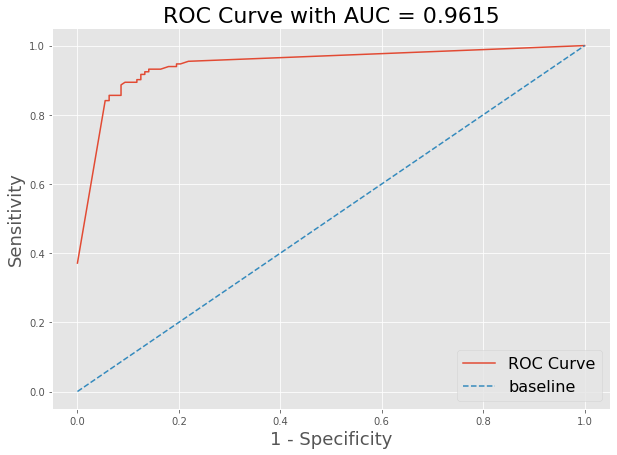

In [267]:
#Create figure
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed blue line in plot.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["validate_values"], pred_df["pred_probs"]),4)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

The roc_auc of the Naive Bayes model is lower than that of the logistic regression models.

Now examine the NB model with identified words ['does', 'work', 'time', 'want', 'use', 'using', 'way', 'assistant', 've', 'tried'] removed.

In [268]:
# Set up a pipeline, p4 with two stages
# 1.CountVectorizer (transformer)
# 2.Naive Bayes(multinomial) (estimator)
# 3.Remove the words ['does', 'work', 'time', 'want', 'use', 'using', 'way', 'assistant', 've', 'tried']

pipe4 = Pipeline([('cvec',CountVectorizer(['googl', 'home', 'googl home', 'googlehom','pixel', 'googlepixel',\
                                           'nest', 'mini', 'hub', 'does', 'work', 'time', 'want', 'use',\
                                           'using', 'way', 'assistant', 've', 'tried'])),\
                  ('nb',MultinomialNB())\
                ])

In [269]:
# Parameters of pipeline object
pipe4.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8',
                   input=['googl', 'home', 'googl home', 'googlehom', 'pixel',
                          'googlepixel', 'nest', 'mini', 'hub', 'does', 'work',
                          'time', 'want', 'use', 'using', 'way', 'assistant', 've',
                          'tried'],
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
 'verbose': False,
 'cvec': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                 input=['googl', 

In [270]:
# Load pipeline object into GridSearchCV to tune CountVectorizer
# Search over the following values of hyperparameters:
# Maximum number of features fit (top no. frequent occur words): 2000, 3000, 4000, 5000
# Minimum number of documents (collection of text) needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

# n-gram: 1 token, 1-gram, or 1 token, 2-gram.
pipe_params = {
    'cvec__max_features': [2_000,3_000,4_000,5_000],\
    'cvec__min_df': [2,3],\
    'cvec__max_df': [0.9,0.95],\
    'cvec__ngram_range': [(1, 1), (1,2)]\
}

In [271]:
# Instantiate GridSearchCV.
"""pipe refers to the object to optimize."""
"""param_grid refer to parameter values to search."""
"""cv refers to number of cross-validate fold."""
gs4 = GridSearchCV(pipe4,\
                  param_grid=pipe_params,\
                  cv=10)

In [272]:
# Fit GridSearch to the cleaned training data.
gs4.fit(X_trainf_clean,y_trainf)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input=['googl', 'home',
                                                               'googl home',
                                                               'googlehom',
                                                               'pixel',
                                                               'googlepixel',
                                                               'nest', 'mini',
                           

In [202]:
# Check the results of the grid search

print(f"Best parameters: {gs4.best_params_}")
print(f"Best score: {gs4.best_score_}")

Best parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}
Best score: 0.9442307692307692


In [273]:
# Save best model as gs4_model.

gs4_model = gs4.best_estimator_

In [274]:
# Score model on training set & testing set
print(f"First Naive Bayes Model")
print(f"Accuracy on train set: {gs3_model.score(X_trainf_clean, y_trainf)}")
print(f"Accuracy on validate set: {gs3_model.score(X_validate_clean, y_validate)}")
print()
print(f"Second Naive Bayes Model")
print(f"Accuracy on train set: {gs4_model.score(X_trainf_clean, y_trainf)}")
print(f"Accuracy on validate set: {gs4_model.score(X_validate_clean, y_validate)}")

First Naive Bayes Model
Accuracy on train set: 0.9528846153846153
Accuracy on validate set: 0.8961538461538462

Second Naive Bayes Model
Accuracy on train set: 0.9701923076923077
Accuracy on validate set: 0.9423076923076923


Removal of the identified words for the naive bayes model actually improved the validate accuracy. Again the model is slightly overfitted, byt the degree of overfitting is reduced (3% for second model vs. 6% for the first model).

We review the sensitivity and specificity, and roc_auc scores before concluding which of the models is the better performing one.

In [275]:
# Confusion matrix on the first naive bayes model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is googlehome
preds4 = gs4.predict(X_validate_clean)
cm = confusion_matrix(y_validate, preds4)
cm_df = pd.DataFrame(cm,columns=['pred googlepixel','pred googlehome'], index=['Actual googlepixel','Actual googlehome'])
cm_df

,pred googlepixel,pred googlehome
Actual googlepixel,116,12
Actual googlehome,3,129


With a higher test accuracy, there is an overall lower number of False positive/ False negatives in validate prediction for the second Naive Bayes model. In particular, there is a significant decrease in the number of false negatives compared to the first Naive Bayes model.

In [276]:
# return nparray as a 1-D array.
confusion_matrix(y_validate, preds4).ravel()
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_validate,preds4).ravel()

In [277]:
# Summary of metrics for first naive bayes model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")

Specificity: 0.9062
Sensitivity: 0.9773


In [278]:
# To visualize the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in gs4.predict_proba(X_validate_clean)]

pred_df = pd.DataFrame({'validate_values': y_validate,
                        'pred_probs':pred_proba})
pred_df.head()

,validate_values,pred_probs
1445,0,3.253193e-13
1152,0,9.396531e-28
216,1,9.662100e-01
1001,0,1.550664e-22
1120,0,7.710370e-12


In [279]:
# Calculate ROC AUC.
roc_auc_score(pred_df['validate_values'],pred_df['pred_probs'])

0.9923946496212122

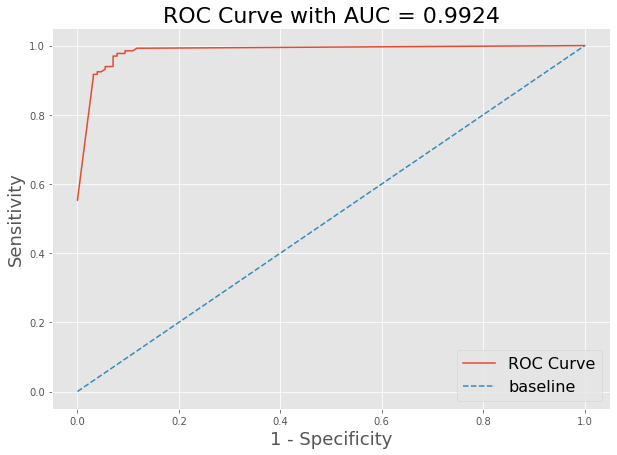

In [280]:
#Create figure
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed blue line in plot.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["validate_values"], pred_df["pred_probs"]),4)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [282]:
# Summary of Model scores in Dataframe
summary_df = pd.DataFrame({'accuracy' : [0.8731, 0.8654, 0.8962, 0.9423],
                          'specificity' : [0.8438, 0.8281, 0.875, 0.9062],
                          'sensitivity' : [0.9015, 0.9015, 0.9167, 0.9773],
                          'roc_auc' : [0.9633, 0.9627, 0.9615, 0.9924]})
# Transpose dataframe
summary_dft = summary_df.T
# Rename columns
summary_dft.columns = ['LogReg','LogReg(words_rmvd)', 'NB', 'NB(words_rmvd)']
summary_dft

,LogReg,LogReg(words_rmvd),NB,NB(words_rmvd)
accuracy,0.8731,0.8654,0.8962,0.9423
specificity,0.8438,0.8281,0.8750,0.9062
sensitivity,0.9015,0.9015,0.9167,0.9773
roc_auc,0.9633,0.9627,0.9615,0.9924


The team prioritization is on correct classification of Google Home posts as google home devices holds the greater proportion of Google IoT devices. In this regard, we would want to pick the model with highest True Positive Rate (sensitivity), for as much correct classification of the google home posts as possible. Considering the models with highest roc_auc, and highest sensitivity (lowest false positives (Type I error)), we pick the NB model(words_rmvd) as the production model.

Deeper Look at the Production (Naive Bayes) Model 
---
For the test accuracy and roc_auc scores, the Naive Bayes is selected as the better performing model. This section examines 
- model performance on test data
- the features that helps with negative (googlepixel) and positive (googlehome) classifications,
- what could be the features that lead to misclassifications.

In [283]:
#Initialize an empty list to hold the clean reviews.
X_train_clean = []

#For whole train set
# Instantiate counter.
j = 0
for text in X_train['selftext']:
    """Convert text to words, then append to X_trainf_clean."""
    X_train_clean.append(selftext_to_words(text))

C:\Users\65943\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://imgur.com/a/telb95S" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\65943\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://imgur.com/a/obeUnIH" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\65943\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://imgur.com/a/Wp9EwEn" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that

In [284]:
# Review model coefficients to see which word is helping with negative / positive classifications)
# As GridSearchCV' object has no attribute 'feature_log_prob_,
# Build separate naive bayes model to enable model coefficient extraction
# using best parameters discovered above in gs4

# Instantiate our CountVectorizer
cv = CountVectorizer(stop_words=['googl', 'home', 'googl home', 'googlehom','pixel','googlepixel', 'nest', 'mini',\
                                 'hub', 'does', 'work', 'time', 'want', 'use',\
                                 'using', 'way', 'assistant', 've', 'tried'],\
                     ngram_range=(1,2),max_df=0.9,min_df=3,max_features=4000)

# Fit and transform on whole training data
X_train_cleancv = cv.fit_transform(X_train_clean)

# Transform test data
X_test_cleancv = cv.transform(X_test_clean)

In [285]:
# Instantiate model
nb = MultinomialNB()

# Fit model on whole training data
model = nb.fit(X_train_cleancv,y_train)

# Generate predictions from test set
predictions = nb.predict(X_test_cleancv)

In [286]:
print(f"Accuracy on whole test set: {model.score(X_test_cleancv, y_test)}")

Accuracy on whole test set: 0.9202453987730062


In [287]:
# Confusion matrix for test set using NB model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is googlehome
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm,columns=['pred googlepixel','pred googlehome'], index=['Actual googlepixel','Actual googlehome'])
cm_df

,pred googlepixel,pred googlehome
Actual googlepixel,147,14
Actual googlehome,12,153


In [288]:
# return nparray as a 1-D array.
confusion_matrix(y_test, predictions).ravel()
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [289]:
# Summary of metrics for first naive bayes model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")

Specificity: 0.913
Sensitivity: 0.9273


In [290]:
# To visualize the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in nb.predict_proba(X_test_cleancv)]

pred_df = pd.DataFrame({'test_values': y_test,
                        'pred_probs':pred_proba})

In [291]:
# Calculate ROC AUC.
roc_auc_score(pred_df['test_values'],pred_df['pred_probs'])

0.9538490495012234

In [292]:
# Summary of the production NB Model scores in Dataframe
summary_df = pd.DataFrame({'accuracy' : [0.9423, 0.9202],
                          'specificity' : [0.9062, 0.913],
                          'sensitivity' : [0.9773, 0.9273],
                          'roc_auc' : [0.9924, 0.9538]})
# Transpose dataframe
summary_dft = summary_df.T
# Rename columns
summary_dft.columns = ['Whole Train set','Test set']
summary_dft

,Whole Train set,Test set
accuracy,0.9423,0.9202
specificity,0.9062,0.9130
sensitivity,0.9773,0.9273
roc_auc,0.9924,0.9538


There is a drop in sensitivity and roc_auc for the test score of the production model. Model appears to have slight overfit on the whole train dataset, since accuracy on test set is higher than that of whole train set. We review the top features for positive and negative classifications.

In [293]:
# The Naive Bayes 'feature_log_prob_' is similar to '.coef_ for MultinomialNB' 
# Utilize this to find the top words (features) in the positive and negative class
import numpy as np
#prob for positive class
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()
#prob for negative class
neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
#getting the top features 
pos_top_features = np.take(cv.get_feature_names(), pos_class_prob_sorted)
neg_top_features = np.take(cv.get_feature_names(), neg_class_prob_sorted)

In [294]:
# List of top 30 words that helps in 'googlehome' (positive) classification
print(pos_top_features[:50])

['right bud' 'the design' 'com galleri' 'phone in' 'the cord' 'app like'
 'truli wireless' 'the comput' 'app goo' 'my right' 'comfort' 'twitter'
 'the charger' 'my pocket' 'ubreakifix' 'my order' 'my opinion'
 'the charg' 'the buzz' 'the bud' 'the ear' 'phone so' 'the earbud'
 'the experi' 'charg case' 'charg it' 'charg the' 'charger' 'charger and'
 'the iphon' 'chat with' 'headset' 'it feel' 'the headphon' 'check for'
 'tomorrow' 'the galaxi' 'the full' 'the flagship' 'the fingerprint'
 'new bud' 'persist' 'aptx' 'touch control' 'comparison' 'unlock it'
 'unlock the' 'data and' 'tax' 'and some']


In [295]:
# List of top 30 words that helps in 'googlepixel' (negative) classification
print(neg_top_features[:30])

['name of' 'chrome cast' 'onli play' 'my playlist' 'bluetooth speaker'
 'just play' 'my roommat' 'command can' 'hop' 'roku' 'my son' 'my speaker'
 'chromecast' 'my spotifi' 'chromecast and' 'chromecast audio' 'my tv'
 'where my' 'tri differ' 'ifttt' 'video call' 'hous is' 'command it'
 'one speaker' 'off light' 'my parent' 'tell it' 'my lenovo' 'gh to'
 'in anoth']


**Googlehome**: For positive class (googlehome), some of the more common words are `charger` related among the top 50 word features. Interestingly, there are some words that are associated the pixel product, such as the word `bud`. Further analysis could be done to determine the reason they are featured within google home posts.

**Googlepixel**: For negative class (googlepixel), the more common word features are `chromecast` related. Pixel phones, and Chromecast-connected TVs can be networked to form an audio entertainment system. So no surprise that `chromecast` is a feature here. Interestingly, there are some words that are more commonly associated with IoT device hubs, such as `off light`. These probably emerge as features for googlepixel classification as the pixel can serve as point of control in the smarthome devices set-up.

**Reviewing the misclassified samples**: What could be the features that lead to misclassifications?

In [304]:
# Pass y_test (pandas series) into dataframe first
# in order to use the original selftext indexes for traceability
actual = pd.Series(y_test)
df_rvw = actual.to_frame()

# Create column of predicted classes from Naive Bayes model

df_rvw['predicted_googlehome'] = predictions
# Include the selftext data
df_rvw['selftext'] = X_test_clean

# Review the dataframe
df_rvw.head()

,googlehome,predicted_googlehome,selftext
919,0,0,so i bought pixel after my phone die and i m s...
1029,0,0,hello i have a pixel xl the last time i use it...
764,1,0,but make sure no kid are around http photo app...
962,0,0,i ve had my p axl sinc launch still haven t go...
1064,0,0,i had a voicemail with case id and the number ...


In [305]:
# Index of misclassified classes
row_ids = df_rvw[df_rvw['googlehome'] != df_rvw['predicted_googlehome']].index
row_ids

Int64Index([ 764,  525, 1571, 1076,  856,  108,  465,  469, 1593, 1251, 1498,
              74, 1416,  749, 1215, 1024,  888, 1316,  864,  729,  258,  145,
             276, 1196,  922,  117],
           dtype='int64')

In [306]:
# Create overview of the misclassified samples
# Use the display function to display objects with better spacing
for i in row_ids:
    display(df_rvw.loc[i])

googlehome                                                              1
predicted_googlehome                                                    0
selftext                but make sure no kid are around http photo app...
Name: 764, dtype: object

googlehome                                                              1
predicted_googlehome                                                    0
selftext                anyon have similar issu sinc lastest updat and...
Name: 525, dtype: object

googlehome                                                              0
predicted_googlehome                                                    1
selftext                okay friend my googl assist ha stop talk to me...
Name: 1571, dtype: object

googlehome                                                              0
predicted_googlehome                                                    1
selftext                hello just recent move from an s to a pixel xl...
Name: 1076, dtype: object

googlehome                                                              0
predicted_googlehome                                                    1
selftext                i use turn off my wifi in pixel xl dure night ...
Name: 856, dtype: object

googlehome                                                              1
predicted_googlehome                                                    0
selftext                the product page onli say w power adaptor dc p...
Name: 108, dtype: object

googlehome                                                              1
predicted_googlehome                                                    0
selftext                i uncov one unwrap og one hub unwrap hub and o...
Name: 465, dtype: object

googlehome                                                      1
predicted_googlehome                                            0
selftext                view poll http www reddit com poll g h ar
Name: 469, dtype: object

googlehome                                                              0
predicted_googlehome                                                    1
selftext                when do a long press of the pixel bud to hear ...
Name: 1593, dtype: object

googlehome                                                              0
predicted_googlehome                                                    1
selftext                there is a set that i disabl a long time ago t...
Name: 1251, dtype: object

googlehome                                                              0
predicted_googlehome                                                    1
selftext                how is it possibl googl advertis a stabl bluet...
Name: 1498, dtype: object

googlehome                                                              1
predicted_googlehome                                                    0
selftext                hello i have a brick googl home mini that wa h...
Name: 74, dtype: object

googlehome                                                              0
predicted_googlehome                                                    1
selftext                so i have pixel phone one og pixel and x a s a...
Name: 1416, dtype: object

googlehome                                                              1
predicted_googlehome                                                    0
selftext                the bull play everi fuck time wtf thi just sta...
Name: 749, dtype: object

googlehome                                                              0
predicted_googlehome                                                    1
selftext                hi i m on my phone a pixel and whenev i m ask ...
Name: 1215, dtype: object

googlehome                                                              0
predicted_googlehome                                                    1
selftext                i have a group text that i chang the group nam...
Name: 1024, dtype: object

googlehome                                                              0
predicted_googlehome                                                    1
selftext                if you use it what do you use it for most of t...
Name: 888, dtype: object

googlehome                                                              0
predicted_googlehome                                                    1
selftext                i m stuck work at home and i have to make a bu...
Name: 1316, dtype: object

googlehome                                                              0
predicted_googlehome                                                    1
selftext                so i have one of those router with one wifi ne...
Name: 864, dtype: object

googlehome                                                              1
predicted_googlehome                                                    0
selftext                my nest hub ha stop tell me when i have a remi...
Name: 729, dtype: object

googlehome                                                              1
predicted_googlehome                                                    0
selftext                how loud is the googl home compar to the mini ...
Name: 258, dtype: object

googlehome                                                              1
predicted_googlehome                                                    0
selftext                i ve seen argument for both but right now both...
Name: 145, dtype: object

googlehome                                                              1
predicted_googlehome                                                    0
selftext                i went past the smart home section at low s ye...
Name: 276, dtype: object

googlehome                                                              0
predicted_googlehome                                                    1
selftext                recent bought a pair of jaybird tarah pro sold...
Name: 1196, dtype: object

googlehome                                                              0
predicted_googlehome                                                    1
selftext                hi guy ani idea whi my photo size rang from mb...
Name: 922, dtype: object

googlehome                                                              1
predicted_googlehome                                                    0
selftext                http imgur com a g kxf t http imgur com a g kx...
Name: 117, dtype: object

Two samples from each of misclassified samples are examined in further detail in this section.

**False Negative**: Predicted as googlepixel post but is actually googlehome post. 
To gain insights into what are the words that caused this post to be misclassified as google pixel post, one approach is to compare the words with the list of words that are strongly associated with the negative class. 

We pick one sample from each of the misclassified examples to illustrate the approach. 

We'll start with the false negative sample.

In [299]:
# Sample a false negative
print(df_rvw['selftext'][108])

the product page onli say w power adaptor dc power jack there are no replac cord on the googl store and i can t get through to support i m fine with get a third parti adapt but i m afraid i ll buy someth that either doesn t work with the nest mini or will somehow fri it ha anyon els had to replac the cord if i get an adapt that is more than w is that a problem or is w just a minimum ani help would be appreci


In [300]:
# split the string of text into list of individual words
review1 = df_rvw['selftext'][108].split() 

In [301]:
# Convert numpy array of words stongly associated with googlepixel post into a list
neg_list = neg_top_features.tolist()

In [302]:
# Print the words that likely contributed to false negative classification for this post
print(set(review1) & set(neg_list))

{'had', 'll', 'on', 'say', 'els', 'cord', 'with', 'will', 'either', 'and', 'ha', 'that', 'more', 'problem', 'just', 'get', 'an', 'anyon', 'someth', 'power', 'page', 'would', 'to', 'are', 'but', 'buy', 'if', 'than', 'help', 'be', 'it', 'there', 'no', 'or', 'is', 'onli', 'fine', 'ani', 'appreci', 'support', 'parti', 'can', 'store', 'jack', 'somehow', 'the', 'adapt', 'third', 'product', 'through', 'doesn', 'replac'}


**False Positive**: Predicted as googlehome post but is actually googlepixel post. 

In [313]:
# Sample a false positive
# split the string of text into list of individual words
print(df_rvw['selftext'][1416])

so i have pixel phone one og pixel and x a s all of them suffer the same symptom at random moment dure use the wifi connect would lose internet connect not wifi connect would not load anyth at all to fix it either i wait long enough and the phone disconnect and reconnect itself to the same wifi or i have to do it manual i have other phone as well and none of them do thi so it can t be a network issu also it doe thi on all wifi network i say all becaus i haven t test all my connect but all that i have use more than minut have had the same result anyon els see thi happen


In [314]:
# split the string of text into list of individual words
review2 = df_rvw['selftext'][1416].split() 

In [315]:
# Convert numpy array of words stongly associated with googlehome post into a list
pos_list = pos_top_features.tolist()

In [316]:
# Return the words that likely contributed to false positive classification.
print(set(review2) & set(pos_list))

{'had', 'internet', 'on', 'all', 'say', 'els', 'connect', 'lose', 'fix', 'also', 'doe', 'of', 'load', 'moment', 'anyth', 'either', 'other', 'and', 'issu', 'result', 'that', 'more', 'dure', 'at', 'wait', 'random', 'itself', 'enough', 'og', 'anyon', 'so', 'have', 'them', 'would', 'to', 'but', 'disconnect', 'than', 'be', 'it', 'minut', 'or', 'see', 'happen', 'test', 'haven', 'my', 'not', 'one', 'becaus', 'network', 'long', 'phone', 'do', 'as', 'wifi', 'well', 'the', 'same', 'thi', 'reconnect', 'none', 'manual', 'can'}


Theorectically, all the posts should be reviewed to better identify the 'culprit' words with strong influence on misclassification. However, care should also be excercised to not overtune the model such that it loses it's generalizability and ends up with increased false positives and false negatives in the predictions.

### Recommendations and Way Forward
---
The second Naive Bayes model is selected as the production model for the classification of googlehome and googlepixel reddit posts. 

Potential enhancements to classification accuracies could be done by 
- further reviewing and identification of the words that contributed to false positives and false negatives,
- and remove these words through count vectorizer. 

Following deployment, further tuning of the model could also be done with the incoming new data. It is also recommended to review the list of words that have been removed so as to tune the production model should it be redeployed to classify rival's product reddit posts (e.g.Apple Iphone, Amazon Alexa)